In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.examples.tutorials.mnist import input_data
import os

## I. Load MNIST

In [2]:
mnist = input_data.read_data_sets('data/', one_hot=True)
train_img = mnist.train.images
train_label = mnist.train.labels

test_img = mnist.test.images
test_label = mnist.test.labels

print("MNIST data is ready")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
MNIST data is ready


## Define Model

In [3]:
n_input = 784
n_channel = 64
n_classes = 10

# placeholder for input and ouputs
X = tf.placeholder(tf.float32, [None, n_input])
Y = tf.placeholder(tf.float32, [None, n_classes])

# Network Parameters
stddev = 0.1

weights = {
    'c1':tf.Variable(tf.random_normal([3,3,1,n_channel], stddev=stddev)),
    'c2':tf.Variable(tf.random_normal([3,3,n_channel,128], stddev=stddev)),
    'd1':tf.Variable(tf.random_normal([7*7*128,n_classes], stddev=stddev)),
}

biases = {
    'c1':tf.Variable(tf.random_normal([n_channel],stddev=stddev)),
    'c2':tf.Variable(tf.random_normal([128],stddev=stddev)),
    'd1':tf.Variable(tf.random_normal([n_classes],stddev=stddev)),    
}

print("Network parameters are ready")

Network parameters are ready


## Define Graph

In [4]:
def CNN(_x, _w, _b):
    _x_r = tf.reshape(_x, shape=[-1,28,28,1])
    
    _conv1 = tf.nn.conv2d(_x_r, _w['c1'], strides = [1,1,1,1], padding='SAME')
    _conv1 = tf.nn.bias_add(_conv1, _b['c1'])
    _conv1 = tf.nn.relu(_conv1)
    _pool1 = tf.nn.max_pool(_conv1, ksize=[1,2,2,1], strides =[1,2,2,1], padding='SAME')
    
    _conv2 = tf.nn.conv2d(_pool1, _w['c2'], strides = [1,1,1,1], padding='SAME')
    _conv2 = tf.nn.bias_add(_conv2, _b['c2'])
    _conv2 = tf.nn.relu(_conv2)
    _pool2 = tf.nn.max_pool(_conv2, ksize=[1,2,2,1], strides =[1,2,2,1], padding='SAME')
    
    _dense = tf.reshape(_pool2, [-1, _w['d1'].get_shape().as_list()[0]])
    
    _logit = tf.add(tf.matmul(_dense, _w['d1']), _b['d1'])
    
    _out = {
        'x_r':_x_r, 'conv1':_conv1, 'pool1':_pool1, 'conv2':_conv2, 'pool2':_pool2, 'logit':_logit
    }
    return _out

cnnout = CNN(X, weights, biases)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=cnnout['logit']))
optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

corr = tf.equal(tf.argmax(cnnout['logit'],1), tf.argmax(Y,1))
accr = tf.reduce_mean(tf.cast(corr, tf.float32))

init = tf.global_variables_initializer()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



## Saver

In [5]:
savedir = 'nets/cnn_mnist_simple/'
saver = tf.train.Saver(max_to_keep=3)
save_step = 4
if not os.path.exists(savedir):
    os.makedirs(savedir)    

In [6]:
training_epochs = 20
batch_size = 100
display_step = 4

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(training_epochs):
        avg_cost = 0.
        
        total_batch = int(mnist.train.num_examples/batch_size)

        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            feeds = {X: batch_xs, Y: batch_ys}
            sess.run(optm, feed_dict=feeds)
            avg_cost += sess.run(cost, feed_dict=feeds)
        avg_cost = avg_cost / total_batch

        if (epoch+1) % display_step == 0:
            print(f"Epoch: {epoch+1}/{training_epochs} cost: {avg_cost}")
            feeds = {X:batch_xs, Y:batch_ys}
            
            train_acc = sess.run(accr, feed_dict=feeds)
            print(f"Test accuracy: {train_acc}")
            
        if (epoch+1) % save_step == 0:
            savename = savedir+"net-"+str(epoch+1)+".ckpt"
            saver.save(sess, savename)
            print("saved")
            
print("Optimization has finished")

Epoch: 4/20 cost: 0.029900886874476618
Test accuracy: 0.9900000095367432
saved
Epoch: 8/20 cost: 0.009657811602545818
Test accuracy: 0.9900000095367432
saved
Epoch: 12/20 cost: 0.003522863940624203
Test accuracy: 0.9900000095367432
saved
Epoch: 16/20 cost: 0.0016322366402164335
Test accuracy: 1.0
saved
Epoch: 20/20 cost: 0.0009170430060757181
Test accuracy: 1.0
saved
Optimization has finished


## Restore

In [7]:
do_restore = 1
if do_restore == 1:
    sess=tf.Session()
    epoch = 20
    savename = savedir+"net-"+str(20)+".ckpt"
    saver.restore(sess, savename)
else:
    print("Nothing happened")

INFO:tensorflow:Restoring parameters from nets/cnn_mnist_simple/net-20.ckpt


In [8]:
input_r = sess.run(cnnout['x_r'], feed_dict={X: train_img[0:1]})
conv1 = sess.run(cnnout['conv1'], feed_dict={X: train_img[0:1]})
pool1 = sess.run(cnnout['pool1'], feed_dict={X: train_img[0:1]})
conv2 = sess.run(cnnout['conv2'], feed_dict={X: train_img[0:1]})
pool2 = sess.run(cnnout['pool2'], feed_dict={X: train_img[0:1]})
out = sess.run(cnnout['logit'], feed_dict={X: train_img[0:1]})

Text(0.5, 1.0, '7')

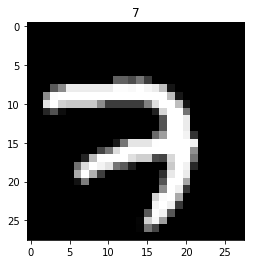

In [10]:
plt.imshow(input_r.squeeze(), cmap='gray')
plt.title(np.argmax(train_label[0]))

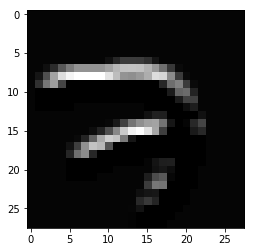

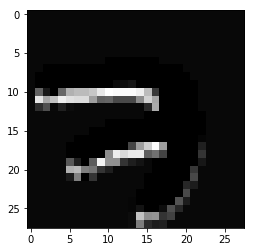

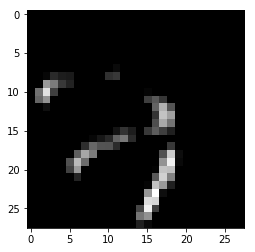

In [12]:
for i in range(3):
    plt.figure()
    plt.imshow(conv1[0,:,:,i], cmap='gray')

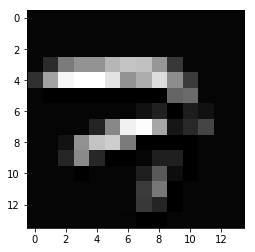

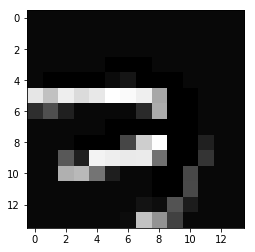

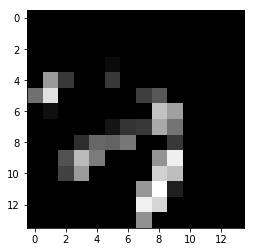

In [13]:
for i in range(3):
    plt.figure()
    plt.imshow(pool1[0,:,:,i], cmap='gray')

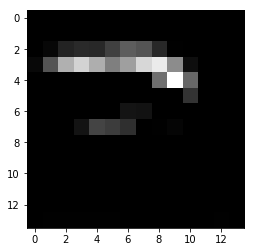

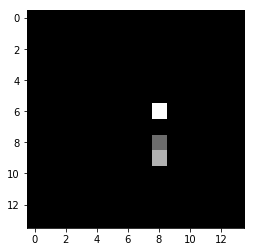

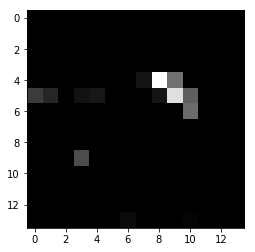

In [14]:
for i in range(3):
    plt.figure()
    plt.imshow(conv2[0,:,:,i], cmap='gray')

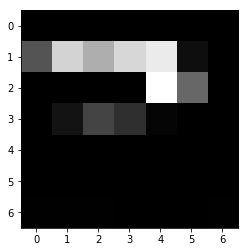

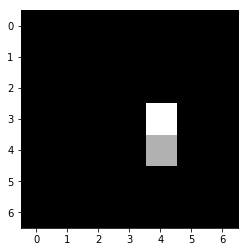

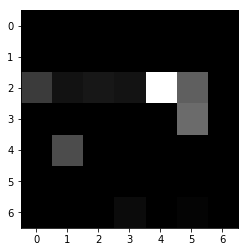

In [15]:
for i in range(3):
    plt.figure()
    plt.imshow(pool2[0,:,:,i], cmap='gray')